# Part II - What loan characteristics are associated with a high number of investors?
## by Harnex Kakandelwa

## Investigation Overview


My goal was to find out what loan characteristics are associated with a high number of investors. For this, I looked at how the association between risk level and investors was influenced by other variables (which included loan term, employment status and borrower type). I also looked at the interaction between investors and the estimated return and loan amount.

In terms of the findings, the data seemed to support the proposition that relatively low interest rates could signify low risk thus making such loans more attractive to investors. Delving deep into this, the data seemed to suggest that loans associated with borrowers that can be classified as low risk were indeed likely to be funded by investors regardless of the other variables considered. The results also suggested that loan amount has an influence on the level of estimated return at which lenders are more likely to fund a loan.


## Dataset Overview

The dataset coverered over 100,000 loans with information related to the listing, loan amount, number of investors, interest rate, current loan status, borrower's employment status, income and so on. For the final analysis, data points with unverifiable income and extremely large stated monthly income values were removed from the dataset.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loan_df = pd.read_csv('prosperLoanData.csv')

In [3]:
# Make copy of data frame
loan_df_clean = loan_df.copy()

In [4]:
# Treat all prosper scores that are greater than 10 as null
for score in loan_df_clean.ProsperScore:
    if score > 10:
        loan_df_clean.at[loan_df_clean[loan_df_clean['ProsperScore']==score].index[0], 'ProsperScore'] = np.NaN

In [5]:
# Get the average prosper score for loans that have different scores and store in a new column

# Function to compute mean of specified column for duplicate rows 
def get_mean_for_duplicates(data, duplicate_value, column_with_duplicates, column_to_compute):
    return data[data[column_with_duplicates]==duplicate_value][column_to_compute].mean()

In [6]:
duplicated_loan_numbers = list(loan_df_clean.query('LoanNumber.duplicated(keep=False)')['LoanNumber'].unique())
average_prosper_score_for_duplicates = []

# Loop through the loan numbers in the dataframe and compute 
# the mean for the duplicates
for loan_number in loan_df_clean.LoanNumber:
    if loan_number in duplicated_loan_numbers:
        average_prosper_score_for_duplicates.append(get_mean_for_duplicates(loan_df_clean, loan_number, 'LoanNumber', 'ProsperScore'))
    else:
        average_prosper_score_for_duplicates.append(loan_df_clean.at[loan_df_clean[loan_df_clean['LoanNumber']==loan_number].index[0],'ProsperScore'])
        
# Create a new column for prosper score in the dataframe
# The new column is conveniently named "RiskScore"
loan_df_clean.loc[:, 'RiskScore'] = average_prosper_score_for_duplicates

In [7]:
# Drop the rows with duplicate loans
loan_df_clean.drop_duplicates(subset=['LoanNumber', 'ListingNumber', 'ListingKey'], inplace=True)

# Drop the original ProsperScore column
loan_df_clean.drop(columns='ProsperScore', inplace=True)

In [8]:
# Create an empty list to hold the borrower type
# This will be used to create the new column
borrower_type_list = []

duplicated_member_keys = loan_df.query('MemberKey.duplicated(keep=False)')['MemberKey'].unique()

for member in loan_df_clean.MemberKey:
    if member in duplicated_member_keys:
        borrower_type_list.append("Old")
    else:
        borrower_type_list.append("New")
        
loan_df_clean.loc[:, 'BorrowerType'] = borrower_type_list

In [9]:
# Change the "Employed" values to "Full-time" to avoid ambiguity in employment status
loan_df_clean['EmploymentStatus'].replace("Employed", "Full-time", inplace=True)

In [10]:
# Make a copy of the clean dataframe for further exploration
master_loan_df = loan_df_clean.copy()

In [11]:
# For the rest of the exploration, I want to change the values in the IsBorrowerHomeowner 
#and IncomeVerifiable columns from the boolean values "True" and "False" to "Yes" and 
#"No" respectively.
master_loan_df.IsBorrowerHomeowner.replace({True:'Yes', False:'No'}, inplace=True)
master_loan_df.IncomeVerifiable.replace({True:'Yes', False:'No'}, inplace=True)

In [12]:
# Function for labelling plots
def set_plot_labels(plot_title=None, x_label=None, y_label=None, title_fontsize = 14, axis_fontsize = 13):
    plt.title(plot_title, fontsize=title_fontsize)
    plt.xlabel(x_label, fontsize=axis_fontsize)
    plt.ylabel(y_label, fontsize=axis_fontsize)

In [13]:
# Function to create a histogram with custom defined bins
def custom_hist(data, column, left_most, bin_width):
    bins = np.arange(left_most, data[column].max()+bin_width, bin_width)
    plt.hist(data=data, x=column, bins=bins)

In [14]:
# Function to define how categories should be ordered 
# in a bar chart if the column is of type string
def category_order(data, column, order='desc', order_list=None):
    sorted_list = None
    if order == 'desc':
        sorted_list = list(data[column].value_counts().sort_values(ascending=False).index)
    elif order == 'asc':
        sorted_list = list(data[column].value_counts().sort_values().index)
    elif order == 'custom':
        try:
            if len(order_list) == len(list(data[column].value_counts().index)):
                sorted_list = order_list
            else:
                print("Length of custom list does not match the categories in the data")
        except (TypeError, ValueError, IndexError) as err:
            print("Not a valid custom list:", err)
            
    return sorted_list

In [15]:
# For instances where the color in the plot has to be the same, 
# will make use of the variable 'default_color'
default_color = sns.color_palette()[0]

# Most of the plots will have number of loans and number of 
# investors on one of the axis. So will make use of global 
# variables as titles for such axes
common_loan_axis_title = "Number of loans"
common_investor_axis_title = "Number of investors"

## Distribution of the number of investors

The distribution of the number of investors is long-tailed. For most of the loans, the number of investors is from 1 to 100. Only in a few cases, do we have more than 500 investors funding a loan. In extremely few cases, we have more than 900 investors.

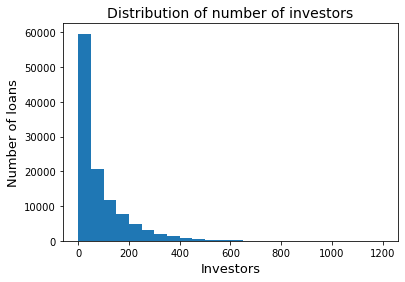

In [16]:
custom_hist(data=master_loan_df, column='Investors', left_most=0, bin_width=50)
set_plot_labels(plot_title="Distribution of number of investors", x_label="Investors", y_label=common_loan_axis_title);

In [17]:
def create_bins(data, intervals, labels, include_lower_limit=False):
    return pd.cut(data, intervals, labels = labels, include_lowest=include_lower_limit)

In [18]:
# use the create_bins function to create a column "RiskLevel" 
# that classifies the risk scores
master_loan_df.loc[:,'RiskLevel'] = create_bins(data=master_loan_df.RiskScore, intervals=[1,4.5,9,10], labels=['High', 'Moderate', 'Low'], include_lower_limit=True)

In [19]:
# Change the data type of the "RiskLevel" column
cat_dtype = pd.api.types.CategoricalDtype(categories=['Low','Moderate','High'], ordered=True)
master_loan_df['RiskLevel'] = master_loan_df['RiskLevel'].astype(cat_dtype)

master_loan_df.RiskLevel.dtype

CategoricalDtype(categories=['Low', 'Moderate', 'High'], ordered=True)

## Relationship between the number of investors and interest rate

Although there is no clear relationship between interest rate and the number of investors, its actually unusual that loans with high interest rates, for example, close to 50% are associated with very few investors while loans with interest rates between 10% and 25% seem to be associated with a very high number of investors. Could it be that low interest rates signify low risk and therefore more attractive to investors?

To see this clearly, let's check if there is a relationship between interest rate and risk level.

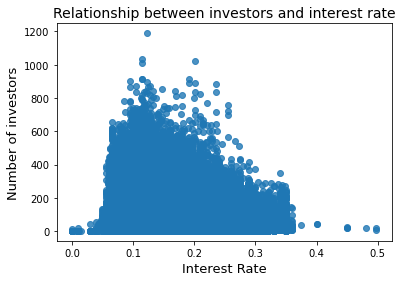

In [20]:
sns.regplot(data=master_loan_df, y='Investors', x='BorrowerRate', fit_reg=False)
set_plot_labels(plot_title="Relationship between investors and interest rate", 
                x_label="Interest Rate", y_label=common_investor_axis_title);

### Risk Level and Interest Rate

The data seems to suggest that indeed most of the loans that are associated with borrowers that are in the low risk category have lower interest rates than loans for moderate and high risk borrowers. Even in terms of the median, loans associated with borrowers in the high risk category have the highest median interest rate while loans for low risk borrowers have the lowest. This could explain why loans with relatively low interest rates seem to be associated with a high number of investors. Perhaps most investors are risk averse?

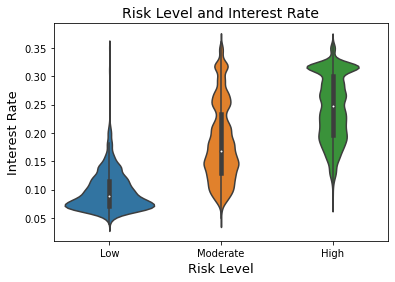

In [21]:
sns.violinplot(data=master_loan_df, x='RiskLevel', y='BorrowerRate')
set_plot_labels('Risk Level and Interest Rate', 'Risk Level', 'Interest Rate');

In [22]:
# Create a copy of the master_loan_df
final_loan_df = master_loan_df.copy()

In [23]:
"""
In this section, I want to only work with loans that are associated 
with verifiable income and do not have outliers in stated monthly 
income (in this case, values exceeding $ 50000). This approach is 
supported by the checks that I carried out in the previous section 
on the StatedMonthlyIncome column, which suggested that the extremely 
large monthly income values may have been a result of errors.
"""

# Drop the rows that have unverified income and 
# stated monthly income greater than $ 50000
rows_to_drop = final_loan_df.query('StatedMonthlyIncome > 50000 & IncomeVerifiable == "No"').index
final_loan_df.drop(rows_to_drop, inplace=True)

### How is the association between risk level and investors influenced by other variables?

#### Investors, Risk Level and Loan Term
Across all loan terms, loans associated with borrowers who can be categorized as low risk have the highest median number of investors followed by loans for moderate risk borrowers. For loans associated with moderate and high risk borrowers, the median number of investors seems to be decreasing as the loan term increases. This suggests that investors are less likely to fund loans associated with risky borrowers if the term is long, for example, 36 months or more.

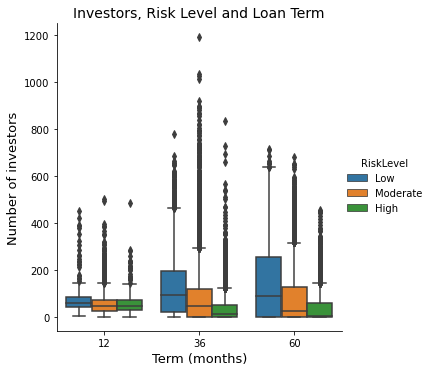

In [26]:
plt.rcParams["figure.figsize"]=(12,6)
sns.catplot(data=final_loan_df, x='Term', y='Investors', hue='RiskLevel', kind='box')
set_plot_labels(plot_title="Investors, Risk Level and Loan Term", x_label="Term (months)", 
                y_label='Number of investors');

#### Investors, Risk Level and Borrower Type

Loans associated with low risk borrowers have a similar median number of investors for both old and new borrowers. This seems to suggest that borrowers who are categorized as low risk are more likely to have their loans funded regardless of whether they are getting a loan for the first time or not.

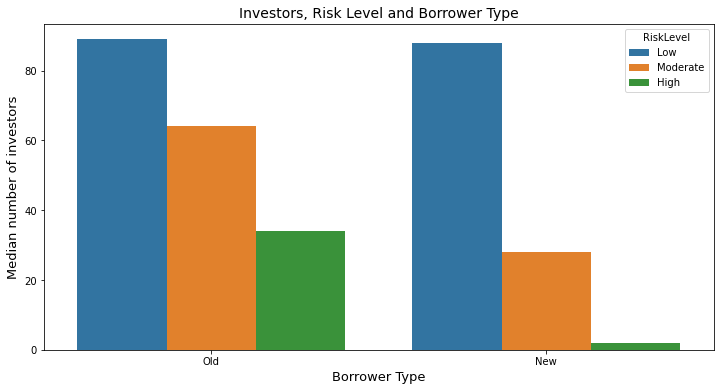

In [27]:
sns.barplot(data=final_loan_df, x='BorrowerType', y='Investors', hue='RiskLevel', estimator=np.median, ci=None)
set_plot_labels(plot_title="Investors, Risk Level and Borrower Type", x_label="Borrower Type", y_label='Median number of investors');

#### Investors, Risk Level and Employment Status

The data shows that loans associated with full-time and low risk borrowers have the highest median number of investors. Interestly, however, is how loans associated with retired and part-time borrowers have a higher median number of investors across all the risk levels than loans associated with self-employed borrowers and even full-time borrowers (in the case of moderate and high risk). This means that, generally, loans associated with part-time or retired borrowers have a higher median number of investors than those for full-time or self-employed borrowers.

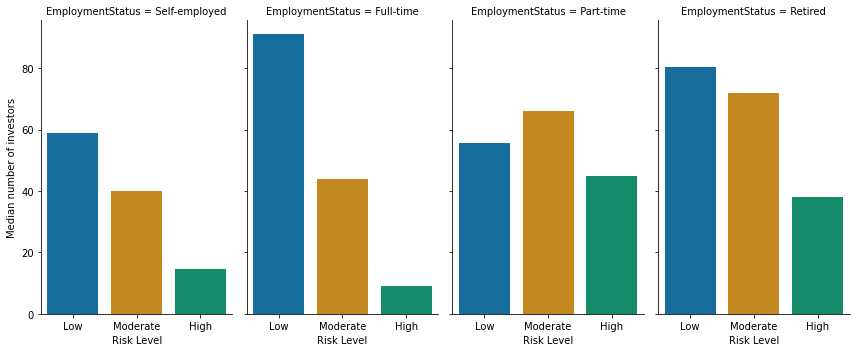

In [28]:
fg = sns.catplot(data=final_loan_df[final_loan_df['EmploymentStatus'].isin(['Self-employed', 'Full-time', 'Part-time', 'Retired'])], 
            x='RiskLevel', y='Investors', kind='bar', col='EmploymentStatus', aspect=0.6, estimator=np.median, ci=None,
           orient='v', palette=sns.color_palette('colorblind'))

fg.set(xlabel="Risk Level", ylabel="Median number of investors");

In [ ]:
!jupyter nbconvert Part_II_slide_deck.ipynb --to slides --post serve --no-input --no-prompt